# Moving Average

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
style.use('ggplot')

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None, color=None):
  plt.plot(time_[start:end], series_[start:end], format_, label=label, lw=1.5, color=color)
  plt.xlabel('Time')
  plt.ylabel('Value')

  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1 / np.exp(3 * season_time))

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  return amplitude * seasonal_pattern(season_time=season_time)

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time_)) * noise_level

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [0]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


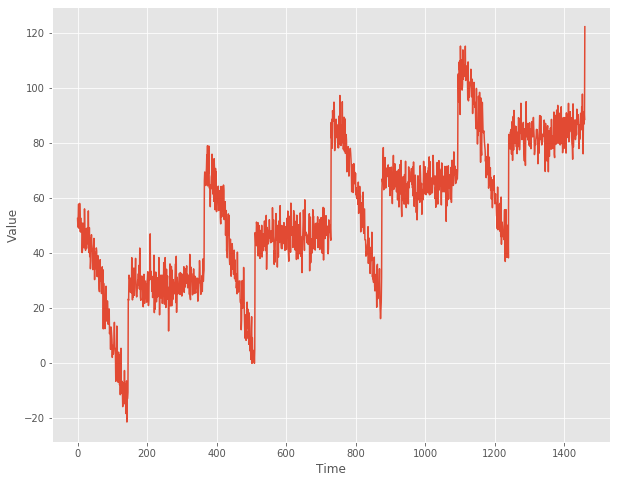

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_, series_=series_)
plt.show()

In [0]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of observations in training period   : {}".format(len(x_train)))
print("Number of observations in validation period : {}".format(len(x_valid)))

Number of observations in training period   : 1000
Number of observations in validation period : 461


### Naive Forecasts

In [0]:
naive_forecast = series_[split_time-1:-1]
print(x_train[-1])
print(x_valid)
print(naive_forecast)
print(series_[-1])

67.19673416803768
[ 71.34471371  68.98551494  64.67519969  61.15735421  67.89843149
  66.39030291  68.91468503  67.63070049  69.7190049   61.81174015
  71.0918342   65.51008011  74.915873    61.11138224  73.25515699
  65.58317034  61.35506451  62.211521    63.04826468  66.79013535
  67.30303871  61.8401661   64.60694517  75.46036708  73.40727142
  66.97195535  65.00137499  65.43277204  67.92169834  59.76187207
  63.61091006  56.57705977  66.9385108   68.20101574  62.57196852
  72.88092156  58.90546664  57.73594625  66.20382215  70.34101191
  73.54932937  62.85965153  70.57206865  65.01092175  64.36533348
  69.67198015  68.54070825  57.42274772  72.71322451  72.25699176
  62.25493006  67.38816456  67.90589429  66.76590023  62.73798368
  62.1585591   65.41625898  71.4352132   68.3172915   63.77412404
  69.51377508  51.44083364  71.45581837  57.04204055  63.95719932
  60.20002271  59.35410512  71.6609575   63.54779797  67.64847176
  65.71116443  68.36095165  66.39000103  59.62123704  71.0

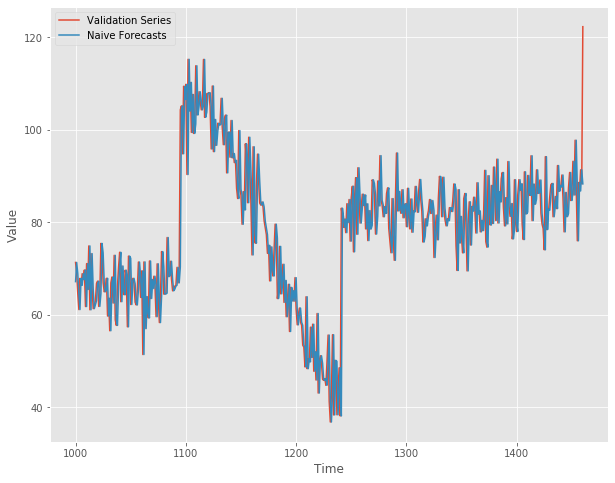

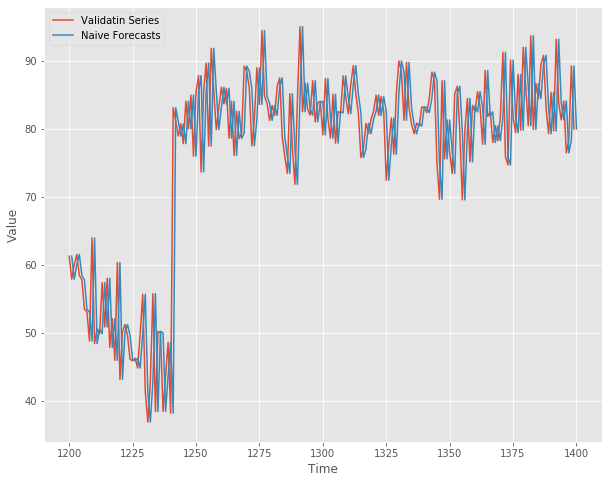

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label='Validation Series')
plot_the_series(time_=time_valid, series_=naive_forecast, label='Naive Forecasts')
plt.show()

plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, start=200, end=400, label="Validatin Series")
plot_the_series(time_=time_valid, series_=naive_forecast, start=201, end=401, label="Naive Forecasts")
plt.show()

In [0]:
naive_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
naive_forecast_mae

5.9379085153216735

### Moving Averages

In [0]:
x = np.array([1, 2, 4, 7, 0])
print(x)

x0 = np.diff(x, n=0)
print(x0)

x1 = np.diff(x, n=1)
print(x1)

x2 = np.diff(x, n=2)
print(x2)

x3 = np.diff(x, n=3)
print(x3)

x4 = np.diff(x, n=4)
print(x4)

x5 = np.diff(x, n=5)
print(x5)

x6 = np.diff(x, n=6)
print(x6)

[1 2 4 7 0]
[1 2 4 7 0]
[ 1  2  3 -7]
[  1   1 -10]
[  0 -11]
[-11]
[]
[]


In [0]:
x = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(x)

x1 = np.cumsum(x)
print(x1)

x2 = np.cumsum(x, axis=0)
print(x2)

x3 = np.cumsum(x, axis=1)
print(x3)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]]
[ 1  3  6 10 15 21 28 36 45 55]
[[ 1  2  3  4  5]
 [ 7  9 11 13 15]]
[[ 1  3  6 10 15]
 [ 6 13 21 30 40]]


In [0]:
forecast_mv_1 = list()
window_size = 30

for ind in range(len(series_)-window_size):
  forecast_mv_1.append(series_[ind:ind+window_size].mean())

forecast_mv_1 = np.array(forecast_mv_1)
print(len(forecast_mv_1))

1431


In [0]:
window_size = 30

mov = np.cumsum(series_)
mov[window_size:] = mov[window_size:] - mov[:-window_size]

forecast_mv_2 = mov[window_size-1:-1] / window_size
print(len(forecast_mv_2))

1431


In [0]:
print(forecast_mv_1)
print(forecast_mv_2)

[48.11584702 47.80889607 48.00546539 ... 86.12726837 86.41023212
 86.59984838]
[48.11584702 47.80889607 48.00546539 ... 86.12726837 86.41023212
 86.59984838]


In [0]:
forecast_mv_1 == forecast_mv_2

array([False, False,  True, ..., False, False, False])

In [0]:
series_dum = np.arange(1, 11)
print(series_dum)

[ 1  2  3  4  5  6  7  8  9 10]


In [0]:
forecast_mv_1_dum = list()
window_size_dum = 3

print("{}\n".format(series_dum))

for ind in range(len(series_dum)-window_size_dum):
  print("{} --> {}".format(series_dum[ind:ind+window_size_dum], 
                                   series_dum[ind:ind+window_size_dum].mean()))
  forecast_mv_1_dum.append(series_dum[ind:ind+window_size_dum].mean())

forecast_mv_1_dum = np.array(forecast_mv_1_dum)
print("\n{}".format(forecast_mv_1_dum))

[0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]

[1 2 3] --> 2.0
[2 3 4] --> 3.0
[3 4 5] --> 4.0
[4 5 6] --> 5.0
[5 6 7] --> 6.0
[6 7 8] --> 7.0
[7 8 9] --> 8.0

[2. 3. 4. 5. 6. 7. 8.]


In [0]:
window_size_dum = 3

print(series_dum)

mov_dum = np.cumsum(series_dum)
print(mov_dum)

mov_dum[window_size_dum:] = mov_dum[window_size_dum:] - mov_dum[:-window_size_dum]
print(mov_dum)

print(mov_dum[window_size_dum-1:-1])

forecast_mv_2_dum = mov_dum[window_size_dum-1:-1] / window_size_dum
print(forecast_mv_2_dum)

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  3  6 10 15 21 28 36 45 55]
[ 1  3  6  9 12 15 18 21 24 27]
[ 6  9 12 15 18 21 24]
[2. 3. 4. 5. 6. 7. 8.]


In [0]:
print(forecast_mv_1_dum == forecast_mv_2_dum)

[ True  True  True  True  True  True  True]


In [0]:
def moving_average_forecast(series_, window_size):
  forecasts_mv = list()
  for ind in range(len(series_)-window_size):
    forecasts_mv.append(series_[ind:ind+window_size].mean())
  
  forecasts_mv = np.array(forecasts_mv)
  return forecasts_mv

In [0]:
def moving_average_forecast(series_, window_size):
  mov = np.cumsum(series_)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  forecasts_mv = mov[window_size-1:-1] / window_size
  return forecasts_mv

In [0]:
window_size = 30
moving_avg = moving_average_forecast(series_=series_, window_size=window_size)[split_time-window_size:]

print(len(moving_avg))

461


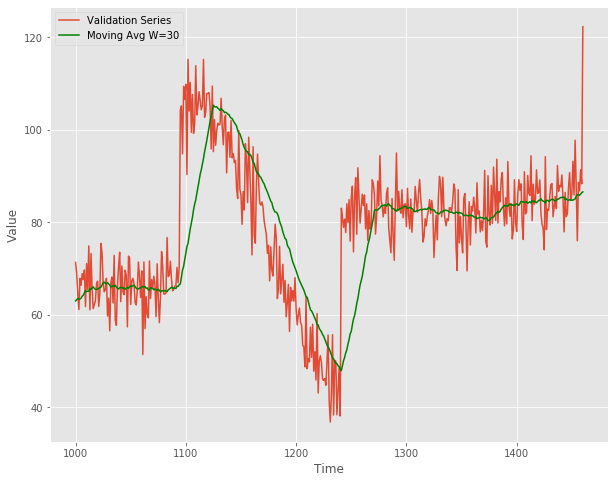

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=moving_avg, label="Moving Avg W=30", color='g')
plt.show()

In [0]:
moving_avg_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
moving_avg_forecast_mae

7.1424185706207854

### Differencing

In [0]:
diff_ind = 365 # year-wise differencing

time_diff = time_[diff_ind:]

# Series(t) - Series(t-diff_ind)
series_diff = series_[diff_ind:] - series_[:-diff_ind]

print(time_diff)
print(series_diff)
print(len(series_diff))

[ 365  366  367 ... 1458 1459 1460]
[13.76032688 20.06178391 15.07451931 ... 24.43903434 17.95270637
 17.96130298]
1096


In [0]:
diff_arr_dum = np.array([])
diff_ind = 365

for i in range(len(time_)):
  diff_arr_dum = np.append(diff_arr_dum, series_[i]-series_[i-diff_ind])

diff_arr_dum = diff_arr_dum[diff_ind:]
print(diff_arr_dum)
print(len(diff_arr_dum))

[13.76032688 20.06178391 15.07451931 ... 24.43903434 17.95270637
 17.96130298]
1096


In [0]:
print(series_diff == diff_arr_dum)

[ True  True  True ...  True  True  True]


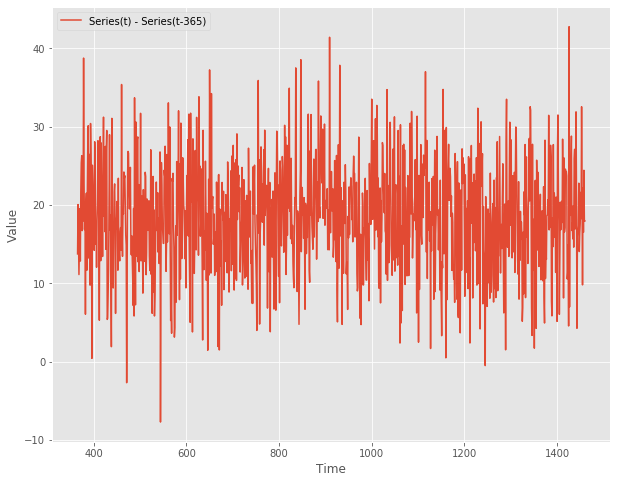

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_diff, series_=series_diff, label="Series(t) - Series(t-365)")
plt.show()

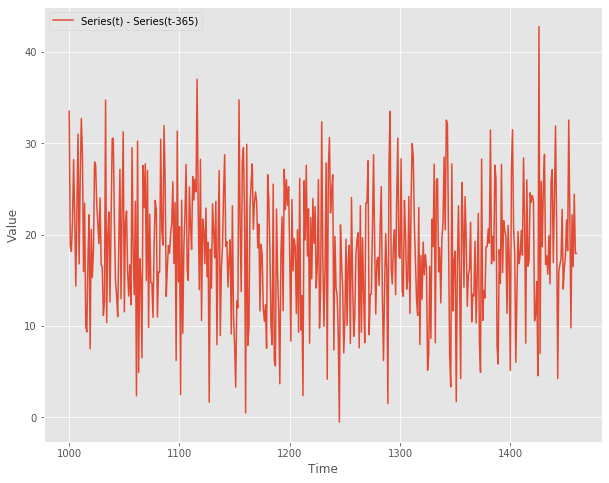

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=series_diff[split_time-diff_ind:], label="Series(t) - Series(t-365)")
plt.show()

### Moving Average on Differenced Series

In [0]:
window_size = 50
diff_moving_avg = moving_average_forecast(series_=series_diff, window_size=window_size)[split_time-diff_ind-window_size:]

print(len(diff_moving_avg))

461


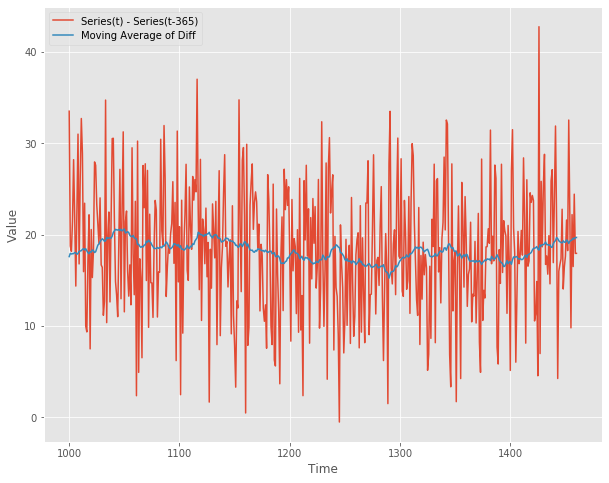

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=series_diff[split_time-diff_ind:], label="Series(t) - Series(t-365)")
plot_the_series(time_=time_valid, series_=diff_moving_avg, label="Moving Average of Diff")
plt.show()

Bring the `trend` and `seasonality` by adding the past values from `t-365`

In [0]:
diff_moving_avg_plus_past = series_[split_time-diff_ind:-diff_ind] + diff_moving_avg

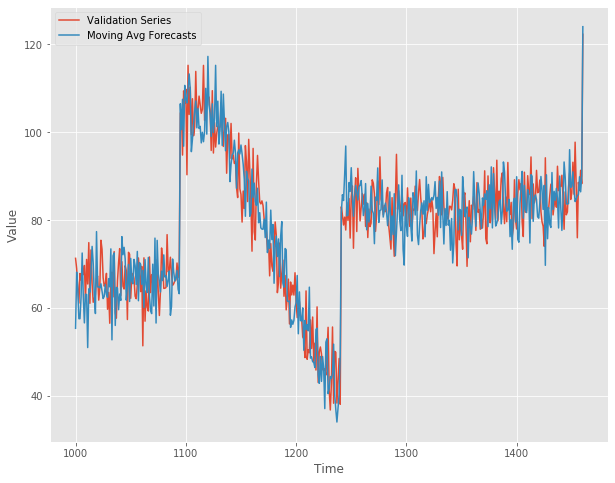

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=diff_moving_avg_plus_past, label="Moving Avg Forecasts")
plt.show()

In [0]:
moving_avg_diff_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
moving_avg_diff_forecast_mae

5.8393105629958955

In [0]:
diff_moving_avg_smooth_past = moving_average_forecast(series_=series_[split_time-(diff_ind+5):-(diff_ind-6)], window_size=11) + diff_moving_avg

print(len(diff_moving_avg_smooth_past))

461


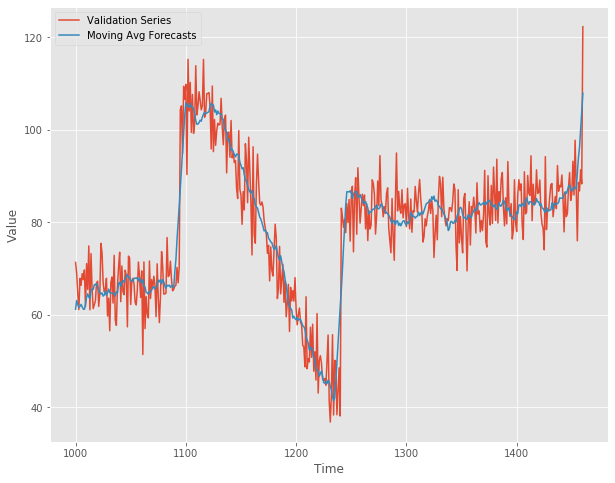

In [0]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=diff_moving_avg_smooth_past, label="Moving Avg Forecasts")
plt.show()

In [0]:
diff_moving_avg_smooth_past_forecast_mae = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_smooth_past).numpy()
diff_moving_avg_smooth_past_forecast_mae

4.566859958970772